In [1]:
import numpy as np
import pandas as pd
import  scipy.signal as sg

import requests
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import mplfinance as mpf



In [2]:

def fetch_historical_data(base_curr, quote_curr, start_time, end_time, granularity=86400):
    """
    Fetches all available historical OHLCV data from Coinbase API.
    
    Args:
    - base_curr (str): Cryptocurrency base (e.g., "BTC", "ETH").
    - quote_curr (str): Cryptocurrency base (e.g., "USDT").
    - start_time (str): Start date in "YYYY-MM-DD" format.
    - end_time (str): End date in "YYYY-MM-DD" format.
    - granularity (int): Timeframe in seconds (default: 86400 for daily data).
    
    Returns:
    - pd.DataFrame: Dataframe containing all historical OHLCV data.
    """

    # Convert symbol format (BTCUSDT -> BTC-USD)
    pair = f"{base_curr}-{quote_curr}"

    url = f"https://api.exchange.coinbase.com/products/{pair}/candles"
    
    # Convert start_time and end_time to datetime objects
    start_dt = datetime.strptime(start_time, "%Y-%m-%d")
    end_dt = datetime.strptime(end_time, "%Y-%m-%d")

    all_data = []
    
    while start_dt < end_dt:
        batch_end = min(end_dt, start_dt + timedelta(seconds=granularity * 300))
        
        params = {
            "granularity": granularity,
            "start": start_dt.strftime("%Y-%m-%dT%H:%M:%SZ"),
            "end": batch_end.strftime("%Y-%m-%dT%H:%M:%SZ")
        }

        response = requests.get(url, params=params)
        
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break

        data = response.json()
        
        if not data:
            print("No data found for this period.")
            break
        
        all_data.extend(data)
        start_dt = batch_end + timedelta(seconds=granularity)

    if not all_data:
        print("No historical data available.")
        return None

    # Convert to DataFrame
    ohlcv = pd.DataFrame(all_data, columns=["timestamp", "low", "high", "open", "close", "volume"])
    ohlcv["timestamp"] = pd.to_datetime(ohlcv["timestamp"], unit="s")
    ohlcv = ohlcv.sort_values("timestamp").reset_index(drop=True)

    return ohlcv

In [3]:
ohlcv = fetch_historical_data("btc", "usdt", "2021-01-01", "2025-03-15")
ohlcv

,timestamp,low,high,open,close,volume
0,2021-05-04,53053.87,56617.70,55608.40,53053.87,253.462479
1,2021-05-05,52938.80,57933.11,53042.22,57486.84,269.341235
2,2021-05-06,55262.28,58361.40,57496.57,56409.60,468.837606
3,2021-05-07,55255.20,58649.79,56429.60,57330.60,456.679212
4,2021-05-08,56959.23,59492.81,57353.12,58865.94,348.770017
...,...,...,...,...,...,...
1407,2025-03-11,76568.32,83631.08,78654.26,82964.97,858.416433
1408,2025-03-12,80598.32,84466.04,82973.79,83682.95,650.069883
1409,2025-03-13,79924.93,84333.22,83695.27,81082.78,593.616611
1410,2025-03-14,80818.41,85302.25,81097.84,83981.73,318.176259


In [4]:
ohlcv.to_csv('data/btc_usdt_2021_2025.csv', index=False)

## Indicator

In [5]:
def sma(price, n):
  return price.rolling(n).mean()

### Simple Moving Averages Cross Over Signals

In [6]:
def sma_crossing_signals(ohlcv, short_window=20, long_window=60):
    ohlcv['SMA_20'] = sma(ohlcv['close'], short_window)
    ohlcv['SMA_60'] = sma(ohlcv['close'], long_window)

    ohlcv['Signal'] = np.where(ohlcv['SMA_20'] > ohlcv['SMA_60'], 1, -1)
    ohlcv['Crossover'] = ohlcv['Signal'].diff().shift(1)

    return ohlcv

In [7]:
def backtest_trading_strategy(ohlcv, cash_to_invest=10000, 
                                initial_position=0,
                                transaction_cash_ratio=0.5,
                                transaction_cost=0.001):
    
    cash_on_hand_list = [cash_to_invest] * len(ohlcv)
    holdings = [initial_position] * len(ohlcv)
    
    total_cash = cash_to_invest  
    for i in range(1, len(ohlcv)):
        
        if ohlcv.loc[ohlcv.index[i], 'Crossover'] == 2:
            invest_amount = total_cash * transaction_cash_ratio  
            position = invest_amount / ohlcv.loc[ohlcv.index[i], 'close'] / (1 + transaction_cost)  # Number of shares to buy
            
            total_cash -= invest_amount
            holdings[i] = position
            cash_on_hand_list[i] = total_cash
        
        elif ohlcv.loc[ohlcv.index[i], 'Crossover'] == -2:
            
            cash_return = holdings[i-1] * ohlcv.loc[ohlcv.index[i], 'close']
            total_cash += cash_return * (1 - transaction_cost)  
            
            holdings[i] = 0  
            cash_on_hand_list[i] = total_cash
        
        else:
            cash_on_hand_list[i] = total_cash
            holdings[i] = holdings[i-1]
    ohlcv['Cash'] = cash_on_hand_list
    ohlcv['Holdings'] = holdings
    ohlcv['Total_equity'] = ohlcv['Cash'] + ohlcv['Holdings']
    
    return ohlcv


In [8]:
def plot_chart(ohlcv):
    ohlcv = ohlcv.copy()

    ohlcv['timestamp'] = pd.to_datetime(ohlcv['timestamp'])
    ohlcv.set_index('timestamp', inplace=True)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(ohlcv.index, ohlcv['SMA_20'], label='SMA 20', color='blue', linestyle='--')
    ax.plot(ohlcv.index, ohlcv['SMA_60'], label='SMA 60', color='red', linestyle='--')

    buy_signals = ohlcv[ohlcv['Crossover'] == 2]  # Golden Cross
    sell_signals = ohlcv[ohlcv['Crossover'] == -2]  # Death Cross

    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal', alpha=1, edgecolor='black')
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal', alpha=1, edgecolor='black')

    ax.legend()
    ax.set_title("SMA Crossover Strategy")
    ax.set_ylabel("Price")
    plt.show()

    fig, ax2 = plt.subplots(figsize=(12, 6))
    ax2.plot(df.index, df['Total_equity'], label='Total Equity', color='green')
    ax2.set_ylabel("Total Equity ($)", color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim([min(ohlcv['Total_equity'].min(), df['Cash'].min()) - 1000, max(ohlcv['Total_equity'].max(), ohlcv['Cash'].max()) + 1000])

    
    
    ax3 = ax2.twinx()
    ax3.plot(ohlcv.index, df['Cash'], label='Cash On Hand', color='orange')
    ax3.set_ylabel("Cash On Hand", color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')

    plt.tight_layout()
    plt.title("Total Equity and Cash On Hand")
    plt.show()
    

    df_mpf = ohlcv[['open', 'high', 'low', 'close', 'volume']].copy()
    mpf.plot(df_mpf, type='candle', style='charles', 
             mav=(20, 60), volume=True, title="Candlestick with SMA", 
             figsize=(12, 6))
    

In [9]:
ohlcv = sma_crossing_signals(ohlcv)
ohlcv = backtest_trading_strategy(ohlcv)
print(f"The final equity is: {ohlcv['Total_equity'].iloc[-1]:.2f} USD")
print(f"The total return is: {(ohlcv['Total_equity'].iloc[-1] - 10000) / 10000 * 100:.2f}%")

The final equity is: 15644.86 USD
The total return is: 56.45%


In [10]:
def plot_chart(df):
    df = df.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # Define the font properties
    title_font = {'family': 'serif', 'weight': 'bold', 'size': 16}

    # First plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['close'], label='closing price', alpha=0.7)
    ax.plot(df.index, df['SMA_20'], label='SMA 20', linestyle='--')
    ax.plot(df.index, df['SMA_60'], label='SMA 60', linestyle='-.')

    buy_signals = df[df['Crossover'] == 2]  # Golden Cross
    sell_signals = df[df['Crossover'] == -2]  # Death Cross

    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal', alpha=1)
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal', alpha=1)

    ax.legend()
    ax.set_title("SMA Crossover Strategy", fontdict=title_font)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.5)
    plt.show()

    # Second plot
    fig, ax2 = plt.subplots(figsize=(12, 6))
    ax2.plot(df.index, df['Total_equity'], label='Total Equity')
    ax2.set_ylabel("Total Equity ($)")
    ax2.tick_params(axis='y')
    ax2.set_ylim([min(df['Total_equity'].min(), df['Cash'].min()) - 1000, max(df['Total_equity'].max(), df['Cash'].max()) + 1000])

    ax3 = ax2.twinx()
    ax3.plot(df.index, df['Cash'], label='Cash On Hand', color='orange')
    ax3.set_ylabel("Cash On Hand", color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')

    plt.tight_layout()
    plt.title("Total Equity and Cash On Hand", fontdict=title_font)
    plt.grid(True, alpha=0.5)
    plt.show()

    # Third plot (Candlestick chart)
    df_mpf = df[['open', 'high', 'low', 'close', 'volume']].copy()
    mpf.plot(df_mpf, 
             type='candle', 
             style='charles', 
             mav=(20, 60), 
             volume=True, 
             title="Candlestick with SMA", 
             figsize=(12, 6),
             warn_too_much_data=5000
             )


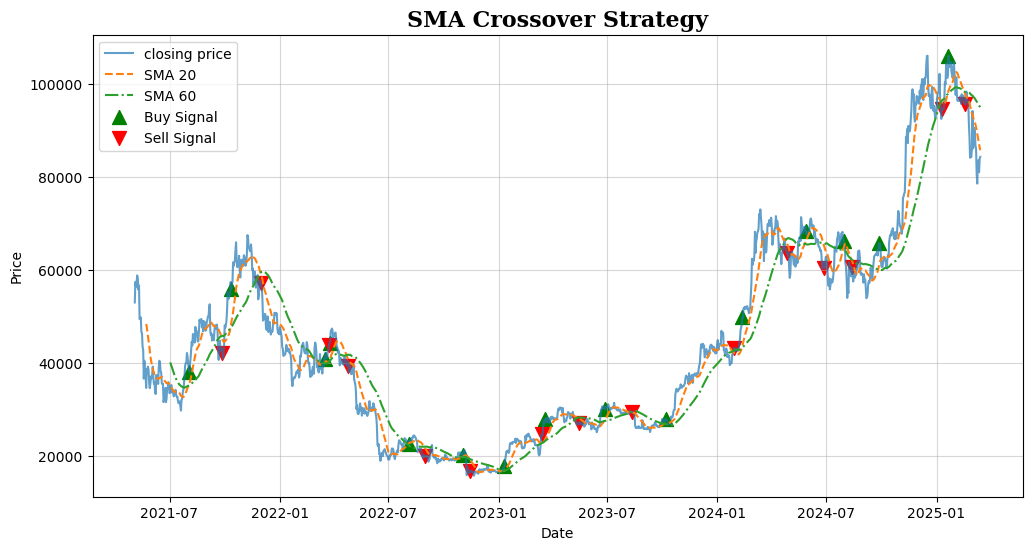

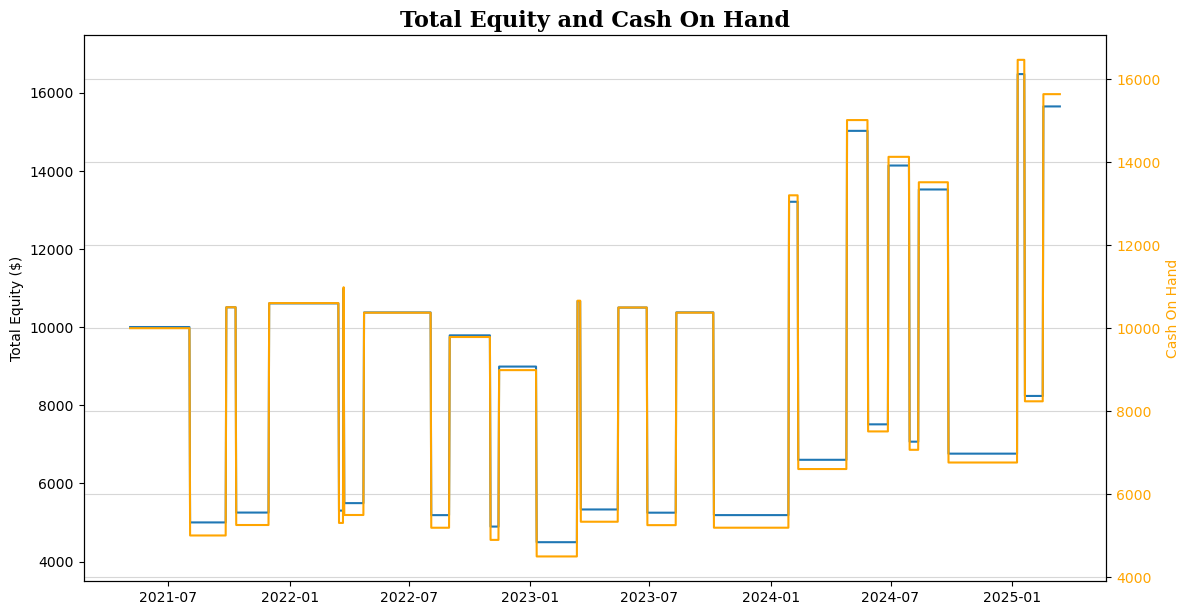

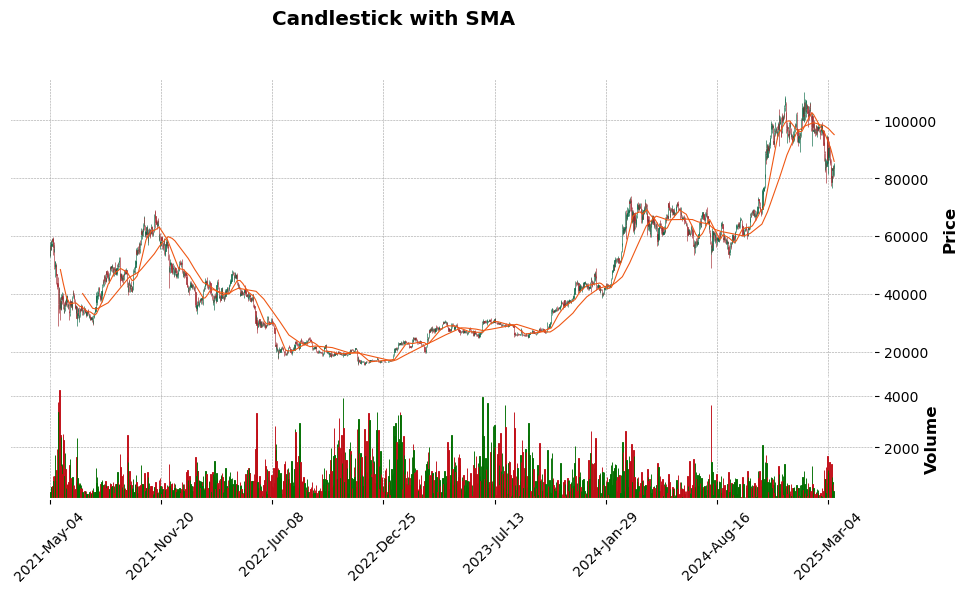

In [11]:
plot_chart(ohlcv)